# UCI Machine Learning - Abalone
Details about the Abalone dataset can be found on the [UCI Site](https://archive.ics.uci.edu/ml/datasets/Abalone).

Load the packages that will be used:

In [1]:
using CSV, DataFrames, Random, Statistics, StatsBase, DataStructures, Pipe, Plots, DecisionTree, MLBase
ENV["COLUMNS"] = 500

500

Download the UCI dataset

In [2]:
download("https://archive.ics.uci.edu/ml/machine-learning-databases/abalone/abalone.data", "abalone.data")

"abalone.data"

Load the data into a DataFrame. The downloaded file contains no headers so we use `rename` to add them:

In [3]:
headers = ["sex", "length", "diameter", "height", "whole_weight", "shucked_weight", "viscera_weight", "shell_weight", "rings"]

df = @pipe CSV.File("abalone.data") |>
DataFrame |>
rename(_, headers);

View a random sample of the data:

In [4]:
rand(eachrow(df), 5) |> DataFrame

,sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings
,String,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Int64
1,M,0.575,0.435,0.13,1.0105,0.368,0.222,0.32,10
2,M,0.64,0.515,0.165,1.369,0.632,0.3415,0.358,10
3,F,0.585,0.45,0.17,0.8685,0.3325,0.1635,0.27,22
4,I,0.47,0.375,0.105,0.441,0.167,0.0865,0.145,10
5,F,0.525,0.425,0.145,0.7995,0.3345,0.209,0.24,15


View a summary of the data:

In [5]:
describe(df)

,variable,mean,min,median,max,nmissing,eltype
,Symbol,Union…,Any,Union…,Any,Int64,DataType
1,sex,,F,,M,0,String
2,length,0.524009,0.075,0.545,0.815,0,Float64
3,diameter,0.407892,0.055,0.425,0.65,0,Float64
4,height,0.139527,0.0,0.14,1.13,0,Float64
5,whole_weight,0.828818,0.002,0.79975,2.8255,0,Float64
6,shucked_weight,0.3594,0.001,0.336,1.488,0,Float64
7,viscera_weight,0.180613,0.0005,0.171,0.76,0,Float64
8,shell_weight,0.238852,0.0015,0.234,1.005,0,Float64
9,rings,9.93247,1,9.0,29,0,Int64


There are no missing values and we only have one `String` column to encode:

In [10]:
sexlabelmap = labelmap(df.sex)
sexencoded = labelencode(sexlabelmap, df.sex)
df.sex = sexencoded;

View a correlation matrix:

In [11]:
@pipe select(df, findall(col -> eltype(col) <: Number, eachcol(df))) |>
Matrix |>
cor(_, _) |>
DataFrame(_, headers) |>
insertcols!(_, 1, :feature => headers)

,feature,sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings
,String,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,sex,1.0,-0.449014,-0.458448,-0.418346,-0.461512,-0.441185,-0.45496,-0.445818,-0.351547
2,length,-0.449014,1.0,0.986813,0.827552,0.925255,0.897905,0.90301,0.897697,0.557123
3,diameter,-0.458448,0.986813,1.0,0.833705,0.925452,0.893159,0.899726,0.905328,0.575005
4,height,-0.418346,0.827552,0.833705,1.0,0.819209,0.774957,0.798293,0.817326,0.558109
5,whole_weight,-0.461512,0.925255,0.925452,0.819209,1.0,0.969403,0.966372,0.955351,0.540818
6,shucked_weight,-0.441185,0.897905,0.893159,0.774957,0.969403,1.0,0.931956,0.882606,0.421256
7,viscera_weight,-0.45496,0.90301,0.899726,0.798293,0.966372,0.931956,1.0,0.907647,0.504274
8,shell_weight,-0.445818,0.897697,0.905328,0.817326,0.955351,0.882606,0.907647,1.0,0.628031
9,rings,-0.351547,0.557123,0.575005,0.558109,0.540818,0.421256,0.504274,0.628031,1.0


What's the distribution of the target, `rings`?

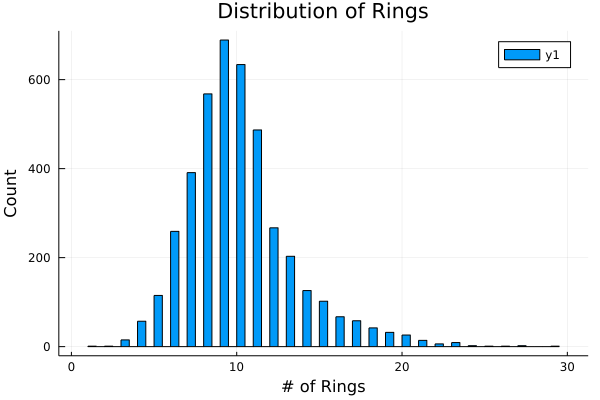

In [12]:
p = plot(title="Distribution of Rings")
xlabel!("# of Rings")
ylabel!("Count")
histogram!(df.rings)

Get random ids for the train and test sets:

In [13]:
lentrain = floor(Int, .7 * nrow(df))
trainids = sample(1:nrow(df), lentrain, replace=false)
testids = setdiff(1:nrow(df), trainids)

@show length(trainids)
@show length(testids)

length(trainids) = 2923
length(testids) = 1253


1253

Define our preprocessing pipeline that will return X and y values for a given dataset:

In [14]:
function normalize(data)
    (data .- mean(data, dims=1)) ./ std(data, dims=1)
end

function pipeline(df::DataFrame)
    X = df[:, Not(:rings)] |> Matrix |> normalize
    y = float.(df[:, :rings])
    (X, y)
end;

Create the training and test datasets using the pipeline:

In [17]:
Xtrain, ytrain = pipeline(df[trainids, :])
Xtest, ytest = pipeline(df[testids, :]);

Create a trained model:

In [18]:
model = build_forest(ytrain, Xtrain)

Ensemble of Decision Trees
Trees:      10
Avg Leaves: 325.5
Avg Depth:  17.5

Get predictions from the test set and calculate rmsd:

In [19]:
@pipe apply_forest(model, Xtest) |>
rmsd(_, ytest)

2.056180428256517

Calculate $R^2$ score:

In [20]:
nfoldCV_forest(ytrain, Xtrain, 3, 2)


Fold 1
Mean Squared Error:     5.189722040164458
Correlation Coeff:      0.7288390426924898
Coeff of Determination: 0.5309789376107156

Fold 2
Mean Squared Error:     5.736699587655525
Correlation Coeff:      0.6882062365694377
Coeff of Determination: 0.4719424127429759

Fold 3
Mean Squared Error:     4.772612256404293
Correlation Coeff:      0.7438357733300861
Coeff of Determination: 0.5506846511099552

Mean Coeff of Determination: 0.5178686671545489


3-element Vector{Float64}:
 0.5309789376107156
 0.4719424127429759
 0.5506846511099552

Randomly sample some test data to see predictions and error:

In [21]:
@pipe sample(1:size(Xtest, 1), 10, replace=false) |>
DataFrame(:predicted => apply_forest(model, Xtest[_, :]), :actual => ytest[_]) |>
insertcols!(_, 3, :error => _.predicted .- _.actual)

,predicted,actual,error
,Float64,Float64,Float64
1,12.1302,7.0,2.37948
2,7.07905,10.0,-5.89171
3,7.60183,11.0,2.4975
4,10.0748,9.0,0.0187698
5,12.8248,6.0,2.74333
6,9.11933,8.0,-1.88155
7,11.295,8.0,-1.56048
8,11.8789,13.0,-0.0516667
9,11.2808,13.0,4.87794


In [23]:
idxsample = sample(1:size(Xtest, 1), 10, replace=false)
dfpreds = DataFrame(:predicted => apply_forest(model, Xtest[idxsample, :]), :actual => ytest[idxsample])

insertcols!(dfpreds, 3, :error => dfpreds.predicted .- dfpreds.actual)

,predicted,actual,error
,Float64,Float64,Float64
1,11.0092,9.0,2.00925
2,14.0275,14.0,0.0275
3,13.3903,17.0,-3.60972
4,10.9038,15.0,-4.09623
5,11.3187,13.0,-1.68127
6,10.4241,10.0,0.424127
7,9.8027,12.0,-2.1973
8,9.64361,10.0,-0.356389
9,10.8679,11.0,-0.132063
